<a href="https://colab.research.google.com/github/onlygoodman/dacon_shopping_sales_predict/blob/main/project_shop_shell009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

001 - 기본적인 전처리 및 성능확인

002 - 새로운 특성 추가 및 연속형 데이터 -> 대대적인 범주화
특성 다음을 사용
['Tem_mean', 'Fuel_mean', 'Unemp_mean', 'Store_mean', 'Week_mean', 'Month_mean', 'Day_mean']

003 - 001에서 사용한 기본적인 특성 재사용 및 전처리 오류 확인

004 - 이상적인 RMSE score 값의 개선이 되지 않기 때문에 RANSACRegressor 모듈을 활용하여 RMSE값 최소화 시도

005 - Pycaret 사용하여 결과도출시도

006 -

007 - 

008 - 코드 정리, 가독성 증대

009 - catboost, xgboost 모델 튜닝하면서 rmse 최소화 시도

- feature importance에서 store mean 이 중요도가 상당히 높게 나옴

- 따라서 조금 더 세분화 시켜서 rmse최소화 시도해보면 더 높은 정확도를 예상 할 수 있을 것이라고 생각

In [ ]:
#설치 이후 런타임 재실행 후 버전확인

!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user

In [1]:
#버전 확인

import sklearn
sklearn.__version__

'0.23.2'

In [ ]:
#설치 시간이 다소 걸림

!pip install pycaret[full]

In [3]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
#설치 후 런타임 재실행

!pip install markupsafe==2.0.1

In [1]:
#jinja2 임포트 후 pycaret 임포트 해야 오류가 나지 않았다.

import jinja2
from pycaret.regression import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import pandas as pd
import numpy as np
from itertools import permutations,combinations
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")


import math #차후 factorial 계산 등 수학적인 계산을 위한 import

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures #특성공학을 사용하기 위한 import
from sklearn.preprocessing import StandardScaler #전처리된 데이터들의 scale을 맞춰주기 위한 import
from sklearn.decomposition import PCA #차원 축소 - 주성분의 개수에 따른 최적화 모델 구현을 위한 import


#model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor


from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score #이후 test.csv 파일의 predict 자료의 score을 매기기 위한 import

# 데이터 셋 준비

In [3]:
# Train dataset은 Label이 존재하지 않음
train_df = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/sample_submission.csv")

In [4]:
#train 데이터 셋 확인
train_df.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [5]:
#test 데이터 셋 확인
test_df.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
0,1,1,05/10/2012,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,6.573,False
1,2,1,12/10/2012,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,6.573,False
2,3,1,19/10/2012,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,6.573,False
3,4,1,26/10/2012,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False
4,5,2,05/10/2012,70.27,3.617,6037.76,NaN,10.04,3027.37,3853.40,6.170,False


근거 추가 必!!!

일,월별 매출의 상관관계가 보였다.
특적 일을 갖는다면 매출이 상대적으로 높았기 때문에 차이를 두기위해 다음과 같이 특성을 추가하였음

In [6]:
#date form change
def datefunc(date):
  d, m ,y = date.split("/")
  return "{}/{}/{}".format(y,m,d)

def monthfunc(date):
  d, m, y = date.split("/")
  return int(m)

def dayfunc(date):
  d, m, y = date.split("/")
  return int(d)

#bool data to one hot encoding
def holiday_to_number(isholiday):
    if isholiday == True:
        number = 1
    else:
        number = 0
    return number

#기존 Date의 형식이 옳지 않아 date값 변경
train_df['Date_new']=train_df['Date'].apply(lambda x: datefunc(x))
test_df['Date_new']=test_df['Date'].apply(lambda x: datefunc(x))  

#기존 Date형식에서 월 columns 추가 -> 차후 월별 매출 등급 부여에 사용
train_df['Month'] = train_df['Date'].apply(lambda x: monthfunc(x))
test_df['Month'] = test_df['Date'].apply(lambda x: monthfunc(x))

#기존 Date형식에서 일 columns 추가 -> 차후 일별 매출 등급 부여에 사용
train_df['Day'] = train_df['Date'].apply(lambda x: dayfunc(x))
test_df['Day'] = test_df['Date'].apply(lambda x: dayfunc(x))

# 이 함수를 IsHoliday 칼럼에 적용한 NumberHoliday 칼럼을 만들어줍니다.
train_df['NumberHoliday'] = train_df['IsHoliday'].apply(holiday_to_number)
test_df['NumberHoliday'] = test_df['IsHoliday'].apply(holiday_to_number)

# data.drop(columns=['ID'])[col]
train_df.drop(columns=['IsHoliday'], inplace = True)
test_df.drop(columns=['IsHoliday'], inplace = True)

train_df.head()
# train_df.to_csv("mydata1.csv")

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,Weekly_Sales,Date_new,Month,Day,NumberHoliday
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,1643690.90,2010/02/05,2,5,0
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,1641957.44,2010/02/12,2,12,1
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,1611968.17,2010/02/19,2,19,0
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,1409727.59,2010/02/26,2,26,0
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,1554806.68,2010/03/05,3,5,0


지점 별 매출액 시각화

x축 : 지점 번호

y축 : 지점별 판매액 -> boxplot으로 그려보면 더 좋을듯

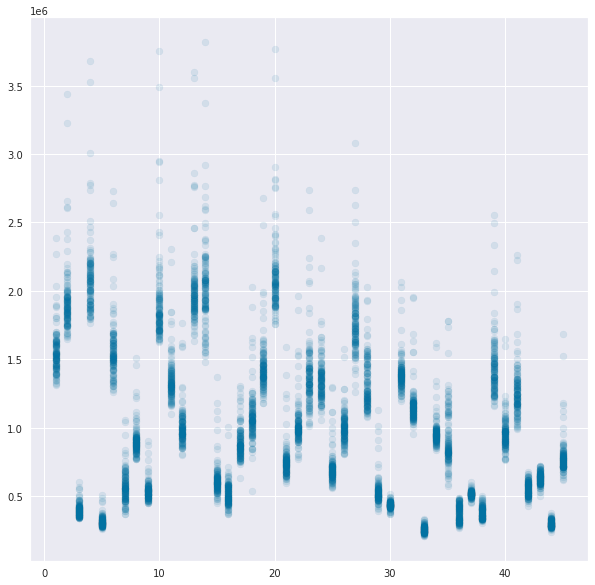

In [7]:
#Store별로 매출액 평균이 유의미한 분포를 갖고 있다. Store별로 outlier 제거 후 평균 

# train_df.plot(kind='line', x=range(len(train_df)), y="Weekly_Sales")
plt.figure(figsize=(10, 10))
plt.scatter(train_df['Store'], train_df['Weekly_Sales'], alpha=0.1)

#stroe name 과 매출액간의 상관관계 시각화

각 특성 별 상관관계

-> 별다른 insight를 얻지는 못하였음.

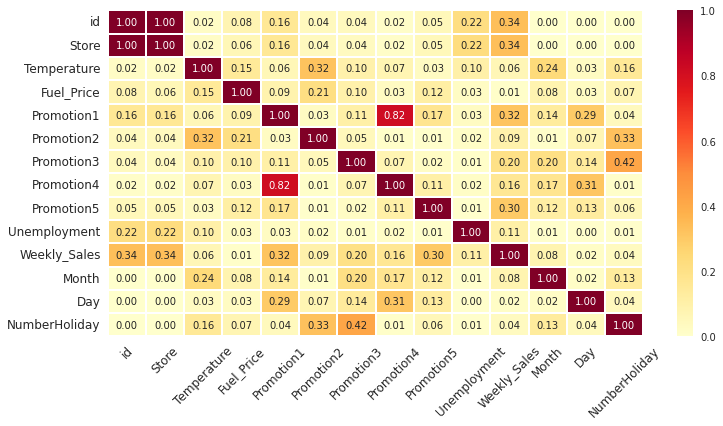

In [8]:
#각 특성 별 상관관계

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(train_df.corr().abs(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.2f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태

plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

promotion 1~5를 적절히 합쳐서 하나의 score으로 특성 추가 하면 유의미한 결과를 얻을 수 도 있을 것 같다.

-> 지금 당장은 제거

In [9]:
#프로모션 칼럼에서 다수의 결측치가 발견되었다.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6255 non-null   int64  
 1   Store          6255 non-null   int64  
 2   Date           6255 non-null   object 
 3   Temperature    6255 non-null   float64
 4   Fuel_Price     6255 non-null   float64
 5   Promotion1     2102 non-null   float64
 6   Promotion2     1592 non-null   float64
 7   Promotion3     1885 non-null   float64
 8   Promotion4     1819 non-null   float64
 9   Promotion5     2115 non-null   float64
 10  Unemployment   6255 non-null   float64
 11  Weekly_Sales   6255 non-null   float64
 12  Date_new       6255 non-null   object 
 13  Month          6255 non-null   int64  
 14  Day            6255 non-null   int64  
 15  NumberHoliday  6255 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 782.0+ KB


In [10]:
#프로모션 칼럼의 결측치를 우선 0으로 대체

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

#우선 promotion은 예측에 방해가 되는 요소인것 같아 제거하고 진행
train_df.drop(columns=['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5'], inplace = True)
test_df.drop(columns=['Promotion1','Promotion2','Promotion3','Promotion4','Promotion5'], inplace = True)


Temperature, Fuel_Price, Unemployment feature과

weeklysales간의 회귀분석을 위해 범주형으로 특성을 추가하고 추후 one-hot-encoding 진행

In [11]:
#Temperature과 Fuel을 범주형으로 나누어 판매액과 비교
def temfunc(temp):
  if temp<47 and temp>-5:
    return 0

  elif temp>=47 and temp<62:
    return 2

  elif temp>=62 and temp<75:
    return 1

  else:
    return 3

def fuelfunc(fuel):
  if fuel<2.917:
    return 2
  
  elif fuel>=2.917 and fuel<3.413:
    return 0
  
  elif fuel>=3.413:
    return 1

def unemplefunc(employ):
  if employ<6.9 and employ>1.8:
    return 1
  elif employ>=6.9 and employ<7.9:
    return 0
  elif employ>=7.9 and employ>8.6:
    return 1
  else:
    return 0

train_df['Tem_level']=train_df['Temperature'].apply(lambda x : temfunc(x))
test_df['Tem_level']=test_df['Temperature'].apply(lambda x : temfunc(x))

train_df['Fuel_level']=train_df['Fuel_Price'].apply(lambda x : fuelfunc(x))
test_df['Fuel_level']=test_df['Fuel_Price'].apply(lambda x : fuelfunc(x))

train_df['Unemp_level']=train_df['Unemployment'].apply(lambda x : unemplefunc(x))
test_df['Unemp_level']=test_df['Unemployment'].apply(lambda x : unemplefunc(x))

In [12]:
#범주별로 평균

temp_mean=train_df[['Tem_level', 'Weekly_Sales']].groupby(['Tem_level']).mean()
fuel_mean=train_df[['Fuel_level', 'Weekly_Sales']].groupby(['Fuel_level']).mean()
emple_mean=train_df[['Unemp_level', 'Weekly_Sales']].groupby(['Unemp_level']).mean()
store_mean=train_df[['Store', 'Weekly_Sales']].groupby(['Store']).mean()
week_mean=train_df[['NumberHoliday', 'Weekly_Sales']].groupby(['NumberHoliday']).mean()

tm = list(temp_mean['Weekly_Sales'].values)
fm = list(fuel_mean['Weekly_Sales'].values)
em = list(emple_mean['Weekly_Sales'].values)
sm = list(store_mean['Weekly_Sales'].values)
wm = list(week_mean['Weekly_Sales'].values)

In [13]:
#범주별 평균 수치를 특성으로 추가

train_df['Tem_mean']= train_df['Tem_level'].apply(lambda x: tm[x])
train_df['Fuel_mean']= train_df['Fuel_level'].apply(lambda x: fm[x])
train_df['Unemp_mean']= train_df['Unemp_level'].apply(lambda x: em[x])
train_df['Store_mean']= train_df['Store'].apply(lambda x : sm[x-1])
train_df['Week_mean']= train_df['NumberHoliday'].apply(lambda x : wm[x])


test_df['Tem_mean']= test_df['Tem_level'].apply(lambda x: tm[x])
test_df['Fuel_mean']= test_df['Fuel_level'].apply(lambda x: fm[x])
test_df['Unemp_mean']= test_df['Unemp_level'].apply(lambda x: em[x])
test_df['Store_mean']= test_df['Store'].apply(lambda x : sm[x-1])
test_df['Week_mean']= test_df['NumberHoliday'].apply(lambda x : wm[x])

월별,요일별 매출액 평균 특성추가

In [14]:
month_mean=train_df[['Month', 'Weekly_Sales']].groupby(['Month']).mean()
day_mean=train_df[['Day', 'Weekly_Sales']].groupby(['Day']).mean()

mm = list(month_mean['Weekly_Sales'].values)
dm = list(day_mean['Weekly_Sales'].values)

In [15]:
train_df['Month_mean']= train_df['Month'].apply(lambda x : mm[x-1])
train_df['Day_mean']= train_df['Day'].apply(lambda x : dm[x-1])


test_df['Month_mean']= test_df['Month'].apply(lambda x: mm[x-1])
test_df['Day_mean']= test_df['Day'].apply(lambda x: dm[x-1])

기온, 연료, 실업률, 월, 일 -> one hot encoding 

In [16]:
for col in  ['Tem_level','Fuel_level','Unemp_level']:
  train_df = pd.get_dummies(train_df, columns = [col])
  test_df = pd.get_dummies(test_df, columns = [col]) 

def fuelfunc2(x):
  return 0


test_df['Fuel_level_0']= test_df['id'].apply(lambda x: fuelfunc2(x))
test_df['Fuel_level_2']= test_df['id'].apply(lambda x: fuelfunc2(x)) 

전처리확인

In [17]:
#target 특성이 하나 더 있으므로 test feature 개수 +1 = train feature 개수

print("train특성 개수:",len(list(train_df.columns)))
print("test특성 개수:",len(list(test_df.columns)))

train특성 개수: 27
test특성 개수: 26


In [18]:
#학습에 더이상 필요 없는 feature 제거

train_df.drop(columns=['id','Store', 'Date','Month','Day'], inplace=True) #'Temperature', 'Fuel_Price','Unemployment',
test_df.drop(columns=['id','Store', 'Date','Month','Day'], inplace=True)

회귀 모델 준비 단계

월, 일별 onehotencoding으로 차원이 급증하였기 때문에 pca 활용하여봐도 좋을 것 같다.

In [35]:
from datetime import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

model = setup(train_df, target = 'Weekly_Sales', 
              fold_shuffle=True,
              fold=15, 
              session_id=530,
              date_features =['Date_new'],
              remove_multicollinearity = True,
              ignore_low_variance = True,
              pca = False,              
              normalize= True,
              n_jobs = -1,
              silent = True,
              remove_outliers= True,
              )

,Description,Value
0,session_id,530
1,Target,Weekly_Sales
2,Original Data,"(6255, 22)"
3,Missing Values,False
4,Numeric Features,17
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4159, 30)"


In [26]:
#평가 지표가 RMSE이기 때문에 sort를 RMSE로 함

top5_model = compare_models(exclude = ['catboost', 'svm'], round=4, n_select = 5, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,4.495209e+04,4.728996e+09,6.847002e+04,9.850000e-01,0.0637,4.610000e-02,1.0313
lightgbm,Light Gradient Boosting Machine,4.830292e+04,5.400862e+09,7.319353e+04,9.829000e-01,0.0678,4.940000e-02,0.1200
rf,Random Forest Regressor,4.944942e+04,6.194645e+09,7.818360e+04,9.804000e-01,0.0677,4.840000e-02,2.1507
et,Extra Trees Regressor,5.122142e+04,6.689062e+09,8.121938e+04,9.789000e-01,0.0710,5.040000e-02,1.8013
gbr,Gradient Boosting Regressor,6.572105e+04,1.023626e+10,1.009006e+05,9.677000e-01,0.0931,6.720000e-02,0.5687
dt,Decision Tree Regressor,6.714902e+04,1.248248e+10,1.111447e+05,9.606000e-01,0.0951,6.510000e-02,0.0493
llar,Lasso Least Angle Regression,8.830791e+04,1.997476e+10,1.403197e+05,9.373000e-01,0.1448,9.910000e-02,0.0200
br,Bayesian Ridge,8.832060e+04,1.997680e+10,1.403277e+05,9.373000e-01,0.1448,9.910000e-02,0.0207
ridge,Ridge Regression,8.833256e+04,1.997720e+10,1.403296e+05,9.373000e-01,0.1449,9.910000e-02,0.0160
lasso,Lasso Regression,8.835642e+04,1.997792e+10,1.403332e+05,9.373000e-01,0.1450,9.920000e-02,0.0833


In [27]:
#최고 모델로만 학습시켰을 때보다 
#단편적인 경험으로 우선 상위모델을 뽑아서 사용할 때의 점수가 더 좋았음

stacker = stack_models(top5_model[:2], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,47039.1335,6.307926e+09,79422.4524,0.9810,0.0645,0.0462
1,45870.3361,4.653318e+09,68215.2355,0.9847,0.0598,0.0429
2,46195.5014,4.175107e+09,64615.0706,0.9856,0.0687,0.0491
3,44053.0849,3.968214e+09,62993.7581,0.9885,0.0570,0.0447
4,44325.5728,4.932284e+09,70230.2227,0.9824,0.0699,0.0466
5,45598.9294,4.707577e+09,68611.7823,0.9859,0.0593,0.0444
6,45648.5473,4.880836e+09,69862.9790,0.9855,0.0615,0.0469
7,39720.5717,3.233432e+09,56863.2711,0.9886,0.0581,0.0429
8,47211.8918,6.465159e+09,80406.2117,0.9786,0.0653,0.0471


In [36]:
xgb = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,41824.6172,3.432663e+09,58588.9297,0.9902,0.0601,0.0459
1,40894.6641,3.409842e+09,58393.8555,0.9894,0.0552,0.0422
2,44321.5859,4.037108e+09,63538.2422,0.9857,0.0593,0.0463
3,40391.5898,3.409574e+09,58391.5586,0.9880,0.0554,0.0416
4,44062.1562,4.050184e+09,63641.0547,0.9864,0.0570,0.0440
5,47036.7070,6.460405e+09,80376.6484,0.9823,0.0714,0.0467
6,49930.5430,6.434889e+09,80217.7578,0.9780,0.0695,0.0490
7,39302.3750,3.357503e+09,57943.9609,0.9902,0.0558,0.0415
8,48128.8164,4.827418e+09,69479.6172,0.9827,0.0680,0.0506


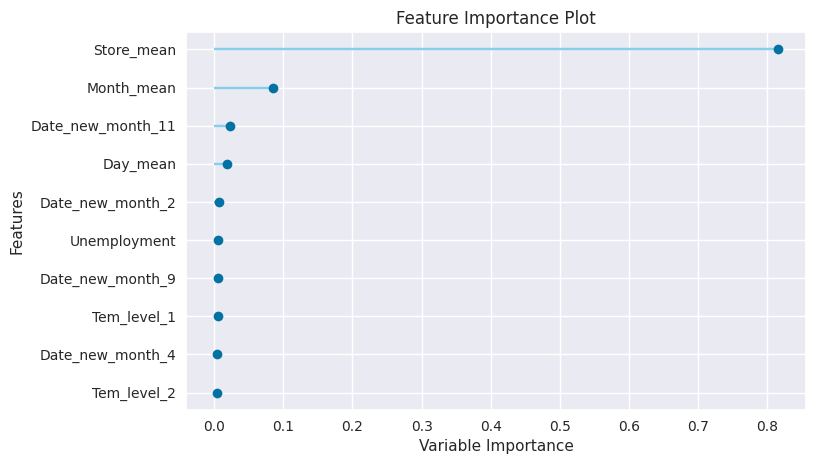

In [37]:
plot_model(xgb, plot='feature')

In [40]:
tuned_xbg = tune_model(xgb, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,45128.3672,3.824521e+09,61842.7148,0.9891,0.0782,0.0537
1,45832.2422,3.943143e+09,62794.4531,0.9877,0.0690,0.0504
2,44585.4453,4.254808e+09,65228.8906,0.9849,0.0741,0.0498
3,41257.1641,3.260445e+09,57100.3047,0.9885,0.0614,0.0450
4,48551.3438,4.828559e+09,69487.8359,0.9838,0.0712,0.0518
5,49011.8242,6.872626e+09,82901.2969,0.9812,0.0774,0.0514
6,51397.7969,5.523806e+09,74322.3125,0.9811,0.0791,0.0558
7,49008.1992,4.666709e+09,68313.3125,0.9864,0.0728,0.0549
8,49567.7891,4.905914e+09,70042.2344,0.9824,0.0779,0.0558


In [ ]:
# blender_specific = blend_models(estimator_list = compare_models(exclude = ['catboost', 'svm'], n_select = 5), method = 'soft')

In [28]:
plot_model(stacker, plot='feature')

TypeError: ignored

In [26]:
#만든 모델의 parameter plot하여 시각화
plot_model(stacker,
           plot = 'parameter')

,Parameters
cv,5
estimators,"[('catboost', <catboost.core.CatBoostRegressor..."
final_estimator,"LinearRegression(copy_X=True, fit_intercept=Tr..."
n_jobs,-1
passthrough,True
verbose,0


In [40]:
stacker.estimators

[('catboost', <catboost.core.CatBoostRegressor at 0x7fa63f711890>),
 ('xgboost',
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
               predictor='auto', random_state=530, reg_alpha=0, ...)),
 ('lightgbm',
  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_ch

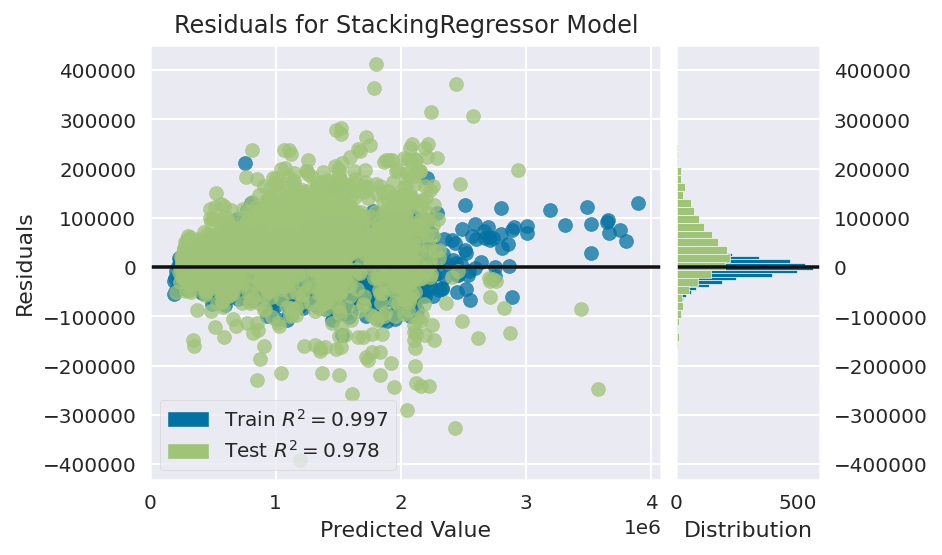

In [38]:
#만든 모델의 feture importance plot하여 시각화
plot_model(stacker,
          scale=2)

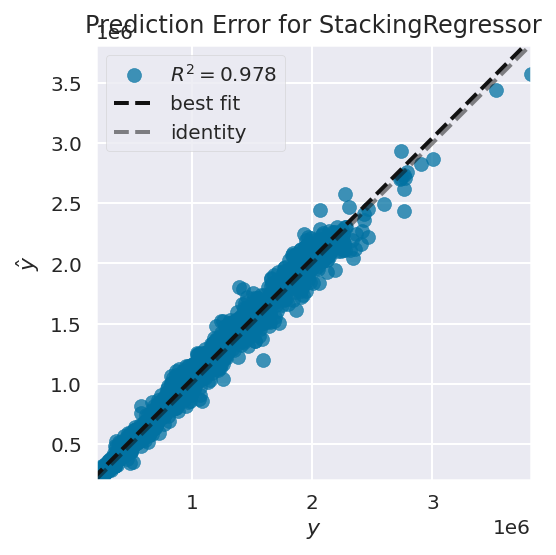

In [34]:
#만든 모델의 RMSE score plot하여 시각화
plot_model(stacker,
           plot = 'error',
           scale = 2,
           save = False,
           verbose= True)

In [37]:
prediction = predict_model(stacker, data=test_df)
pred = prediction['Label'].to_numpy()

filenum = "008"
model = "usePycaret"

# 예측된 값을 정답파일과 병합
# submit['Weekly_Sales'] = pred

# # 정답파일 데이터프레임 확인
# submit.head()
# submit.to_csv('sub004_model_Pycret.csv',index = False)

temp  = pd.read_csv("/content/drive/MyDrive/shopping_sell_dataset/sample_submission.csv")
temp['Weekly_Sales'] = pred

submission = pd.DataFrame({
        "id" : temp['id'],
        "Weekly_Sales" : temp['Weekly_Sales']
})
submission.to_csv('submit{}_model_{}.csv'.format(filenum, model), index = False)